In [1]:
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_dir='../input/paddy-disease-classification/train_images'
test_dir='../input/paddy-disease-classification/test_images'

In [3]:
sample_df=pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
labels_dataframe=pd.read_csv('../input/paddy-disease-classification/train.csv')

In [4]:
labels_dataframe

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
labels_dataframe.shape

(10407, 4)

In [6]:
labels_dataframe.isnull().sum()

image_id    0
label       0
variety     0
age         0
dtype: int64

In [7]:
labels_dataframe['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

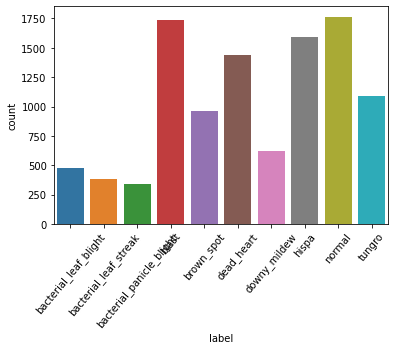

In [8]:
sns.countplot(labels_dataframe['label'])
plt.xticks(rotation=50)
plt.show()

In [9]:
print("No of dog's images in train directory",len(os.listdir(train_dir)))
print("No of dog's images in test directory",len(os.listdir(test_dir)))

No of dog's images in train directory 10
No of dog's images in test directory 3469


In [10]:
diseases_types=sorted(list(set(labels_dataframe['label'])))
n_classes=len(diseases_types)
print(n_classes)
print(diseases_types)

10
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [11]:
classes_to_num=dict(zip(diseases_types,range(n_classes)))
classes_to_num

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [12]:
(train_dir+'/'+labels_dataframe['label']+'/'+labels_dataframe['image_id'])[0]

'../input/paddy-disease-classification/train_images/bacterial_leaf_blight/100330.jpg'

In [13]:
cv2.imread((train_dir+'/'+labels_dataframe['label']+'/'+labels_dataframe['image_id'])[1]).shape

(640, 480, 3)

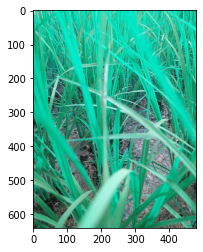

In [14]:
plt.imshow(cv2.imread((train_dir+'/'+labels_dataframe['label']+'/'+labels_dataframe['image_id'])[6660]))
plt.show()

In [15]:
labels_dataframe['file_name']=train_dir+'/'+labels_dataframe['label']+'/'+labels_dataframe['image_id']
labels_dataframe

,image_id,label,variety,age,file_name
0,100330.jpg,bacterial_leaf_blight,ADT45,45,../input/paddy-disease-classification/train_im...
1,100365.jpg,bacterial_leaf_blight,ADT45,45,../input/paddy-disease-classification/train_im...
2,100382.jpg,bacterial_leaf_blight,ADT45,45,../input/paddy-disease-classification/train_im...
3,100632.jpg,bacterial_leaf_blight,ADT45,45,../input/paddy-disease-classification/train_im...
4,101918.jpg,bacterial_leaf_blight,ADT45,45,../input/paddy-disease-classification/train_im...
...,...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55,../input/paddy-disease-classification/train_im...
10403,107811.jpg,tungro,Zonal,55,../input/paddy-disease-classification/train_im...
10404,108547.jpg,tungro,Zonal,55,../input/paddy-disease-classification/train_im...
10405,110245.jpg,tungro,Zonal,55,../input/paddy-disease-classification/train_im...


In [16]:
labels_dataframe['file_name'][0]

'../input/paddy-disease-classification/train_images/bacterial_leaf_blight/100330.jpg'

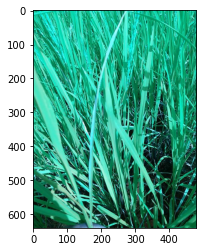

In [17]:
plt.imshow(cv2.imread(labels_dataframe['file_name'][265]))
plt.show()

In [18]:
labels_dataframe['label']=labels_dataframe['label'].map(classes_to_num)
labels_dataframe

,image_id,label,variety,age,file_name
0,100330.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
1,100365.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
2,100382.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
3,100632.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
4,101918.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
...,...,...,...,...,...
10402,107607.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10403,107811.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10404,108547.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10405,110245.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...


In [19]:
y=to_categorical(labels_dataframe['label'])
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
y.shape

(10407, 10)

In [21]:
import keras

In [22]:
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from tensorflow.keras.applications.xception import Xception , preprocess_input as xception_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input as resnet50_preprocess
from tensorflow.keras.layers import concatenate

In [90]:
input_shape=(640,480,3)
input_layer=Input(shape=(input_shape))

In [36]:
labels_dataframe

,image_id,label,variety,age,file_name
0,100330.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
1,100365.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
2,100382.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
3,100632.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
4,101918.jpg,0,ADT45,45,../input/paddy-disease-classification/train_im...
...,...,...,...,...,...
10402,107607.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10403,107811.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10404,108547.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...
10405,110245.jpg,9,Zonal,55,../input/paddy-disease-classification/train_im...


In [37]:
labels_dataframe['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [38]:
labels_dataframe=labels_dataframe.drop(columns=['image_id','variety','age'],axis=1)
labels_dataframe

,label,file_name
0,0,../input/paddy-disease-classification/train_im...
1,0,../input/paddy-disease-classification/train_im...
2,0,../input/paddy-disease-classification/train_im...
3,0,../input/paddy-disease-classification/train_im...
4,0,../input/paddy-disease-classification/train_im...
...,...,...
10402,9,../input/paddy-disease-classification/train_im...
10403,9,../input/paddy-disease-classification/train_im...
10404,9,../input/paddy-disease-classification/train_im...
10405,9,../input/paddy-disease-classification/train_im...


In [94]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
earlystop=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
checkpoint=ModelCheckpoint('kaggle/working/checkpoint',monitor='val_loss',mode='min',save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-3)
my_callbacks=[earlystop,checkpoint,lr]

In [96]:
from tensorflow.keras.optimizers import Adam

In [106]:
diseases_types

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [107]:
train_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=diseases_types,
                                                        color_mode='rgb',
                                                        image_size=(640,480),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        seed=42)

val_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=diseases_types,   
                                                        color_mode='rgb',
                                                        image_size=(640,480),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=42)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [108]:
train_data

<BatchDataset shapes: ((None, 640, 480, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [109]:
val_data

<BatchDataset shapes: ((None, 640, 480, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [110]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.45),
    tf.keras.layers.RandomFlip('horizontal')
])

In [111]:
base_model=tf.keras.applications.EfficientNetB2(include_top=False, pooling='avg', weights='imagenet', input_shape=(640,480,3))

31801344/31790344 [==============================] - 0s 0us/step


In [112]:
base_model

In [113]:
image_batch, label_batch= next(iter(train_data))
feature_batch=base_model(image_batch)
feature_batch.shape

TensorShape([32, 1408])

# applying model

In [114]:
inputs=tf.keras.Input(shape=(640,480,3))
x=data_augmentation(inputs)
x=base_model(x, training=False)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.4)(x)
output=tf.keras.layers.Dense(10, activation='softmax')(x)
model=tf.keras.Model(inputs,output)

In [115]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 640, 480, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 640, 480, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               721408    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0   

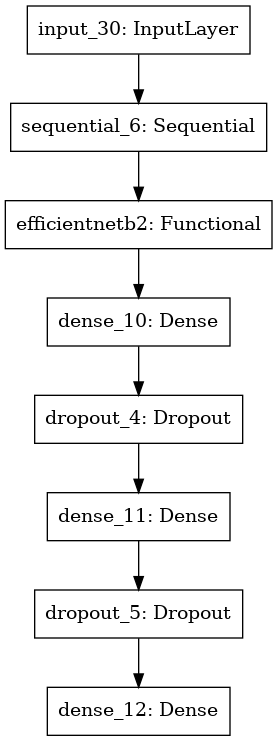

In [116]:
plot_model(model)

In [117]:
for layer in base_model.layers:
    layer.trainable=False

# Fine tuning

In [121]:
for layer1 in base_model.layers[280:]:
    layer1.trainable=True

In [127]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])
callback2=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
history_tuned=model.fit(train_data, validation_data=val_data, epochs=5, callbacks=[callback2] )

Epoch 1/5
261/261 [==============================] - 170s 620ms/step - loss: 0.4180 - accuracy: 0.8652 - val_loss: 0.4068 - val_accuracy: 0.8659
Epoch 2/5
261/261 [==============================] - 160s 612ms/step - loss: 0.3736 - accuracy: 0.8791 - val_loss: 0.3755 - val_accuracy: 0.8770
Epoch 3/5
261/261 [==============================] - 160s 611ms/step - loss: 0.3430 - accuracy: 0.8894 - val_loss: 0.3610 - val_accuracy: 0.8832
Epoch 4/5
261/261 [==============================] - 161s 612ms/step - loss: 0.3304 - accuracy: 0.8918 - val_loss: 0.3484 - val_accuracy: 0.8837
Epoch 5/5
261/261 [==============================] - 161s 614ms/step - loss: 0.3178 - accuracy: 0.8930 - val_loss: 0.3401 - val_accuracy: 0.8842


# test data

In [128]:
test_data=tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/test_images/",
                                                        labels=None,
                                                        label_mode=None,
                                                        color_mode='rgb',
                                                        image_size=(640,480),
                                                        shuffle=False)

Found 3469 files belonging to 1 classes.


In [129]:
predict=tf.argmax(model.predict(test_data),axis=-1)
predict

<tf.Tensor: shape=(3469,), dtype=int64, numpy=array([7, 8, 6, ..., 8, 1, 5])>

In [130]:
predictions=[]
for i in predict:
    predictions.append(diseases_types[i])

In [132]:
predictions[:10]

['hispa',
 'normal',
 'downy_mildew',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

In [133]:
sample_submission=pd.read_csv("/kaggle/input/paddy-disease-classification/sample_submission.csv").drop('label',axis=1)
sample_submission

,image_id
0,200001.jpg
1,200002.jpg
2,200003.jpg
3,200004.jpg
4,200005.jpg
...,...
3464,203465.jpg
3465,203466.jpg
3466,203467.jpg
3467,203468.jpg


In [134]:
final=pd.DataFrame({'image_id': sample_submission.image_id, 'label': predictions})
final.to_csv('submission.csv', index=None)